In [1]:
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import os
import pickle
import webcolors
import pandas as pd

In [2]:
def to_opacity(name, opacity):
    r, g, b = webcolors.hex_to_rgb(name)
    return f"rgba({r}, {g}, {b}, {opacity})"

In [3]:
def get_results(filename, rolling_len=200):
    with open(filename, "rb") as file:
        results = pickle.load(file)
    if len(results[0]) < 5000:
        new_results = []
        for row in results:
            new_results.append([])
            # because ppo from stable-baselines logs after 100 steps
            for item in row:
                new_results[-1].extend([item]*100)
        n = len(new_results[0])
        n = (n // 10000) * 10000
        results = [row[:n] for row in new_results]
    dirname = os.path.dirname(filename)
    rolled_up = []
    frame = []
    for result in results:
        r = pd.Series(result).rolling(rolling_len, min_periods=1).mean().dropna()
        r = list(r)
        rolled_up.append(r)
    frame = pd.DataFrame.from_records(frame)
    rolled_up = np.array(rolled_up)

    avg_rewards = np.mean(rolled_up, 0)
    min_rewards = rolled_up.min(0)
    max_rewards = rolled_up.max(0)
    std_rewards = rolled_up.std(0)

    bot = np.maximum(avg_rewards - std_rewards, min_rewards)
    top = np.minimum(avg_rewards + std_rewards, max_rewards)
    return avg_rewards, bot, top

def to_paper_name(algo: str):
    if algo.startswith("sf_reinforce"):
        return algo.replace("sf_reinforce", "SFR1")
    if algo.startswith("two_sided_sf_reinforce"):
        return algo.replace("two_sided_sf_reinforce", "SFR2")
    return algo

In [4]:
def plot_values(
    fig: go.Figure,
    avg_rewards: np.ndarray,
    top: np.ndarray,
    bot: np.ndarray,
    algo: str,
    color: str,
):
    fig.add_trace(
        go.Scatter(
            y=bot,
            mode="lines",
            line=dict(width=0.01, color=color),
            showlegend=False,
        )
    )  # fill down to xaxis
    fig.add_trace(
        go.Scatter(
            y=top,
            mode="lines",
            line=dict(width=0.01, color=color),
            fill="tonexty",
            fillcolor=to_opacity(color, 0.1),
            showlegend=False,
        )
    )

    fig.add_trace(
        go.Scatter(
            y=avg_rewards,
            mode="lines",
            line=dict(width=2, color=color),
            name=algo,
        )
    )


def update_layout(fig, title):
    fig.update_layout(
        legend=dict(yanchor="bottom", y=0.01, xanchor="right", x=0.99),
        autosize=False,
        width=571,
        height=457,
        plot_bgcolor="white",
        margin=dict(l=20, r=20, t=50, b=20),
        title={
            "text": title,
            "x": 0.53,
            "font": {"size": 15},
        },
    )
    fig.update_xaxes(
        title_text="Episodes",
        mirror=True,
        ticks="outside",
        showline=True,
        linecolor="black",
        gridcolor="lightgrey",
    )
    fig.update_yaxes(
        title_text="Discounted Sum of Rewards",
        mirror=True,
        ticks="outside",
        showline=True,
        linecolor="black",
        gridcolor="lightgrey",
    )

# Base

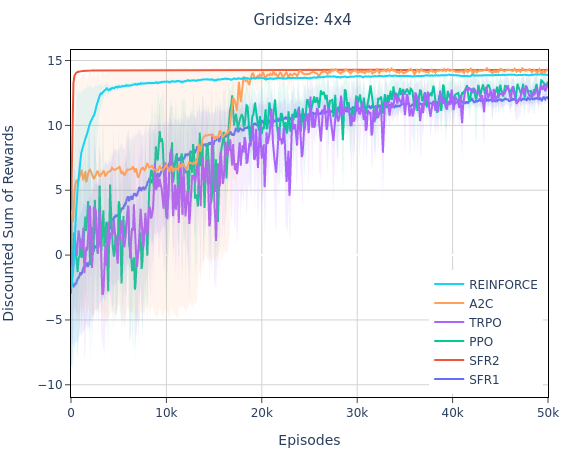

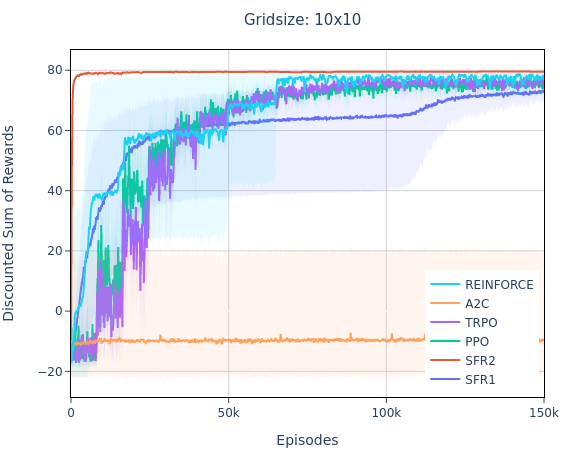

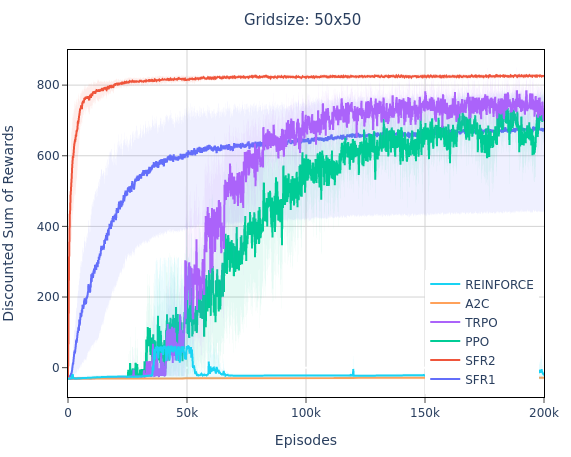

In [5]:
colors = ["red", "green", "blue", "magenta"]
algos = ['sf_reinforce', 'two_sided_sf_reinforce', "ppo", "trpo", "a2c", 'reinforce']

# algos = ['a2c', "ppo"]
gridsizes = ["4x4", "10x10", "50x50"]
grids = ['tiny', 'medium', 'large']
for grid, gridsize in zip(grids, gridsizes):
    fig = go.Figure()
    for color, algo in zip(px.colors.qualitative.Plotly, algos):
        dirname = os.path.join("saves", algo, grid)
        if algo == "sf_reinforce":
            dirname = os.path.join("saves/sf_reinforce_const_0.175", grid)
        elif algo == "two_sided_sf_reinforce":
            dirname = os.path.join("saves/two_sided_sf_reinforce_const_delta=0.175_start_alpha=0.02_grad_bound=1.5", grid)
        if not os.path.exists(dirname):
            continue
        filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
        path = os.path.join(dirname, filename)
        avg_rewards, bot, top = get_results(path)
        plot_values(fig, avg_rewards, top, bot, to_paper_name(algo).upper(), color)

    title = f"Gridsize: {gridsize}"
    update_layout(fig, title)
    fig.write_image(f"plotly_images/{grid}.png", scale=2)
    fig.show(renderer="png")

### Table

In [7]:
# table for experiment 1 different sizes, different algorithm
def change_algo(algo):
    if algo == "sf_reinforce":
        return "SFR-1"
    if algo == "two_sided_sf_reinforce":
        return "SFR-2"
    return algo.upper()

frame = []
algos = ['sf_reinforce', 'two_sided_sf_reinforce', "ppo", "trpo", "a2c", 'reinforce']
gridsizes = ["4x4", "10x10", "50x50"]
grids = ['tiny', 'medium', 'large']
for algo in algos:
    for grid, gridsize in zip(grids, gridsizes):
        dirname = os.path.join("saves", algo, grid)
        if algo == "sf_reinforce":
            dirname = os.path.join("saves/sf_reinforce_const_0.175", grid)
        elif algo == "two_sided_sf_reinforce":
            dirname = os.path.join("saves/two_sided_sf_reinforce_const_delta=0.175_start_alpha=0.02_grad_bound=1.5", grid)
        if not os.path.exists(dirname):
            continue
        filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
        path = os.path.join(dirname, filename)
        with open(path, "rb") as file:
            results = np.array(pickle.load(file))

        per_seed_results = results[:, -200:].mean(1)
        disp = f"{per_seed_results.mean():.2f} +- {per_seed_results.std():.1f}"
        frame.append((gridsize, change_algo(algo), disp))
frame = pd.DataFrame(frame).pivot(index=0, columns=1).reset_index()
frame.columns = ["Gridsize / Algo"] + [col for _, col in frame.columns][1:]
frame = frame[["Gridsize / Algo"]+list(map(change_algo, algos))]
# frame = frame[["Algorithm / Gridsize"] + gridsizes]
display(frame)
print(
    frame
    .to_latex(index=False, escape=True)
    .replace("toprule", "hline")
    .replace("bottomrule", "hline")
    .replace("midrule", "hline")
    .replace("+-", "$\\pm$")
)


,Gridsize / Algo,SFR-1,SFR-2,PPO,TRPO,A2C,REINFORCE
0,10x10,72.66 +- 3.6,79.53 +- 0.1,75.38 +- 0.3,75.77 +- 0.3,-9.60 +- 29.7,76.90 +- 4.9
1,4x4,12.12 +- 0.5,14.28 +- 0.0,12.72 +- 0.2,12.48 +- 0.1,14.20 +- 0.0,13.90 +- 0.1
2,50x50,677.55 +- 233.1,824.96 +- 5.6,682.97 +- 12.9,741.81 +- 10.7,-28.75 +- 5.4,-18.79 +- 8.4


\begin{tabular}{lllllll}
\hline
Gridsize / Algo & SFR-1 & SFR-2 & PPO & TRPO & A2C & REINFORCE \\
\hline
10x10 & 72.66 $\pm$ 3.6 & 79.53 $\pm$ 0.1 & 75.38 $\pm$ 0.3 & 75.77 $\pm$ 0.3 & -9.60 $\pm$ 29.7 & 76.90 $\pm$ 4.9 \\
4x4 & 12.12 $\pm$ 0.5 & 14.28 $\pm$ 0.0 & 12.72 $\pm$ 0.2 & 12.48 $\pm$ 0.1 & 14.20 $\pm$ 0.0 & 13.90 $\pm$ 0.1 \\
50x50 & 677.55 $\pm$ 233.1 & 824.96 $\pm$ 5.6 & 682.97 $\pm$ 12.9 & 741.81 $\pm$ 10.7 & -28.75 $\pm$ 5.4 & -18.79 $\pm$ 8.4 \\
\hline
\end{tabular}



In [ ]:
frame = []
algos = ['sf_reinforce', 'two_sided_sf_reinforce', "ppo", "trpo", "a2c", 'reinforce']
gridsizes = ["4x4", "10x10", "50x50"]
grids = ['tiny', 'medium', 'large']
threshs = [10, 60, 600]
for algo in algos:
    for grid, gridsize, thresh in zip(grids, gridsizes, threshs):
        dirname = os.path.join("saves", algo, grid)
        if algo == "sf_reinforce":
            dirname = os.path.join("saves/sf_reinforce_const_0.175", grid)
        elif algo == "two_sided_sf_reinforce":
            dirname = os.path.join("saves/two_sided_sf_reinforce_const_delta=0.175_start_alpha=0.02_grad_bound=1.5", grid)
        if not os.path.exists(dirname):
            continue
        filename = list(filter(lambda x: x.endswith(".pkl"), os.listdir(dirname)))[0]
        path = os.path.join(dirname, filename)
        avg_rewards, bot, top = get_results(path)

        # find the step when avg_reward crosses thresh
        try:
            step = list(avg_rewards >= thresh).index(True)
        except ValueError:
            step = -1

        frame.append((gridsize, change_algo(algo), step))

frame = pd.DataFrame(frame).pivot(index=0, columns=1).reset_index()
frame.columns = ["Gridsize / Algo"] + [col for _, col in frame.columns][1:]
frame["Thresholds"] = [60,10,600]
frame = frame[["Gridsize / Algo", "Thresholds"]+list(map(change_algo, algos))]
# frame = frame[["Algorithm / Gridsize"] + gridsizes]
display(frame)
print(
    frame
    .to_latex(index=False, escape=True)
    .replace("toprule", "hline")
    .replace("bottomrule", "hline")
    .replace("midrule", "hline")
    .replace("+-", "$\\pm$")
)

,Gridsize / Algo,Thresholds,SFR-1,SFR-2,PPO,TRPO,A2C,REINFORCE
0,10x10,60,30380,344,30098,33656,-1,28837
1,4x4,10,19071,164,16554,20889,16654,1863
2,50x50,600,42680,2177,98462,74272,-1,-1


\begin{tabular}{lrrrrrrr}
\hline
Gridsize / Algo & Thresholds & SFR-1 & SFR-2 & PPO & TRPO & A2C & REINFORCE \\
\hline
10x10 & 60 & 30380 & 344 & 30098 & 33656 & -1 & 28837 \\
4x4 & 10 & 19071 & 164 & 16554 & 20889 & 16654 & 1863 \\
50x50 & 600 & 42680 & 2177 & 98462 & 74272 & -1 & -1 \\
\hline
\end{tabular}



19071